In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data

Collect BTC-USDT order book data from Binance of month 2021-01. 

Data source: Binance -- aggTrades

In [2]:
# get order book data 
raw_data = pd.read_csv(
    r'data\spot\monthly\aggTrades\BTCUSDT\2021-01-01_2022-01-01\BTCUSDT-aggTrades-2021-01.csv',
    names=['aggId', 'price', 'qty', 'firstId', 'lastId', 'timestamp', 'buyerMaker', 'bestMatch'])

raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'], unit='ms')
raw_data.set_index('timestamp', inplace=True)
data = raw_data[['price', 'qty']].copy()
data['volume'] = data['price'] * data['qty']

del raw_data

data.head()


,price,qty,volume
timestamp,,,
2021-01-01 00:00:00.058,28923.63,0.150483,4352.514613
2021-01-01 00:00:00.091,28922.42,0.011199,323.902182
2021-01-01 00:00:00.151,28922.42,0.060036,1736.386407
2021-01-01 00:00:00.158,28922.42,0.000500,14.461210
2021-01-01 00:00:00.400,28922.42,0.000346,10.007157


## The Random Strategy

The strategy: Buy BTC using all capital with simply market order in the first of every 2 hours and sell all the BTC in the next hour.

Parameter setting:
+ Trading frequency: 1 hour
+ Capital amount: $\$$1M
+ Exchange: Binance
+ Trading fee rate: 0.07% (According to a monthly trading volume of over $\$$500M and less than $\$$1Billon)

In [3]:
# set parameters
freq = '1h'
trade_size = 1e6
fee_rate = 0.07 / 100
disct = 1 - fee_rate

In [4]:
def qty_buy(df):
    # this function is called specifically in pd.resample.apply()
    # calculates the quantity of BTC bought using the trading capital
    if df.index[0].hour % 2 == 0:
        tmp = df.iloc[:sum(df['volume'].cumsum() < trade_size) + 1]

        return (tmp['qty'].sum() - (tmp['volume'].sum() - trade_size) / tmp['price'][-1]) * disct

In [5]:
# calculate the purchased quantity of BTC using the trading capital
qty_to_sell = data.resample(freq).apply(qty_buy).shift(1)

for i in range(len(qty_to_sell)):
    data.loc[str(qty_to_sell.index[i])[:13], 'temp_qty'] = qty_to_sell[qty_to_sell.index[i]]


In [6]:
def trading_cost_sell(df):
    # this function is called specifically in pd.resample.apply()
    # calculates the USDT collected from selling all current BTC positions
    if df.index[0].hour % 2 == 1:
        sell_qty = df['temp_qty'][0]
        tmp = df.iloc[:sum(df['qty'].cumsum() < sell_qty) + 1]

        return (tmp['volume'].sum() - (tmp['qty'].sum() - sell_qty) * tmp['price'][-1]) * fee_rate

In [7]:
# calculate the trading cost
selling_cost = data.resample(freq).apply(trading_cost_sell)
trading_cost = selling_cost.replace(np.nan, trade_size * fee_rate)


Text(0.5, 1.0, 'Trading cost of pair BTC-USDT in 2021-01')

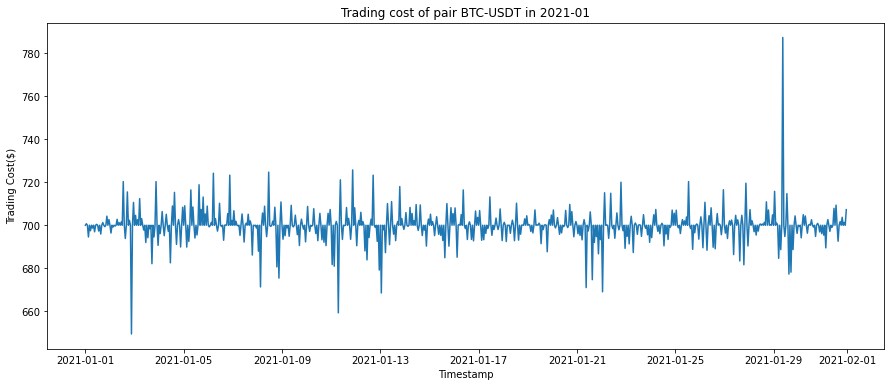

In [9]:
# plot the trading cost
plt.subplots(figsize=(15,6))
plt.plot(trading_cost)
plt.ylabel('Trading Cost($)')
plt.xlabel('Timestamp')
plt.title('Trading cost of pair BTC-USDT in 2021-01')

Trading cost fluctuates around $\$$700, which is $Capital * FeeRate$. A trading cost higher than $\$$700 indicates a rise in BTC price within the 2 hour trading interval.